# Test validity step 4 : $P(B_f | ...) \propto -(d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d-B_c s_c) + \eta^t N_c^{1/2} (S_{approx} + E^t (B^T N^{-1} B)^{-1} E) N_c^{1/2} \eta$

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import emcee
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import non_parametric_ML_compsep as katame
# from mcmc_tools import *

from jax import config
config.update("jax_enable_x64", True)

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_LiteBIRD_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(15, 2, 49152)
(15, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,40.0,37.42,26.46,70.5,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
1,50.0,33.46,23.66,58.5,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
2,60.0,21.31,15.07,51.1,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
3,68.0,16.87,11.93,47.1,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
4,78.0,12.07,8.53,43.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
5,89.0,11.30,7.99,41.5,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
6,100.0,6.56,4.64,37.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
7,119.0,4.58,3.24,33.6,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
8,140.0,4.79,3.39,30.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
9,166.0,5.57,3.94,28.9,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD


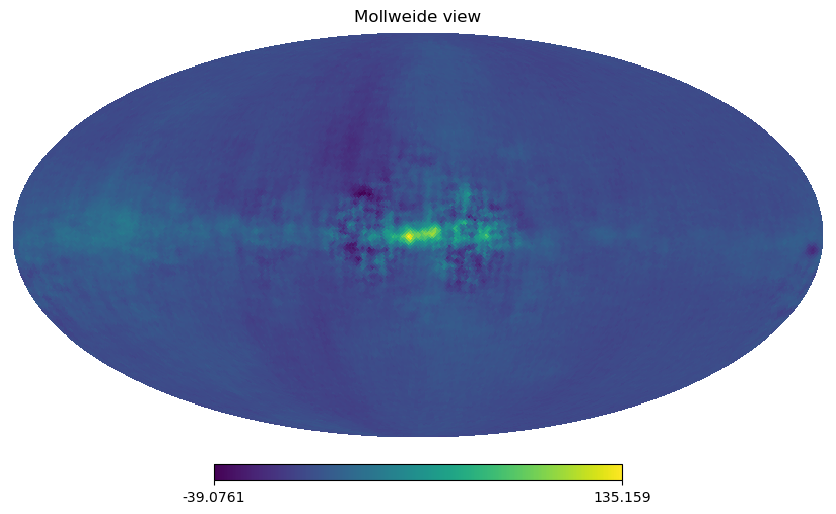

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:
nstokes = 2
nside = 64
lmax = nside*2
lmin = 2

number_frequencies = freq_maps.shape[0]
number_components = 3

limit_iter_cg=2000
tolerance_CG=10**(-12)

n_iter = 8

number_correlations = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

param_dict = {'nside':nside, 'lmax':lmax, 'nstokes':nstokes, 'number_correlations':number_correlations,'number_frequencies':number_frequencies, 'number_components':number_components}
npix = 12*nside**2

In [6]:
all_spectra = generate_power_spectra_CAMB(nside*2, typeless_bool=True)
lensing_spectra = all_spectra['lensed_scalar'][:lmax+1,:]
camb_cls = all_spectra['total'][:lmax+1,:]

c_ells_input = np.zeros((6,lmax+1))
c_ells_input[:4,...] = camb_cls.T
c_ell_approx = np.zeros((6,lmax+1))
c_ell_approx[1] = camb_cls.T[1]
c_ell_approx[2] = lensing_spectra.T[2]


Calculating spectra from CAMB !


In [7]:
indices_polar = np.array([1,2,4])

if nstokes == 2:    
    c_ells_input = c_ells_input[indices_polar,:]
    c_ell_approx = c_ell_approx[indices_polar,:]
    # CMB_map_input = CMB_map_input[1:,:]
    # freq_maps = freq_maps[:,1:,:]

# CMB covariance preparation
red_cov_approx_matrix = katame.get_reduced_matrix_from_c_ell(c_ell_approx)[lmin:,...]
red_cov_matrix = katame.get_reduced_matrix_from_c_ell(c_ells_input)[lmin:,...]

# Mixing matrix initialization
init_mixing_matrix_obj = katame.InitMixingMatrix(np.array(instrument['frequency']), number_components, pos_special_freqs=[-1,0])
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = katame.MixingMatrix(instrument['frequency'], number_components, init_params, pos_special_freqs=[-1,0])
# mixing_matrix_obj.update_params(mixing_matrix_obj.params/100)
mixing_matrix_sampled = mixing_matrix_obj.get_B()


# Noise initialization
depth_p = instrument['depth_p']
freq_inverse_noise = katame.get_noise_covar(depth_p, nside)
cp_cp_noise = katame.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
cp_freq_inv_noise_sqrt = katame.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
cp_freq_inv_noise = katame.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

## Sampling $\eta$ : $P(\eta | ...) \propto \eta^t (S_{approx} + E^t (B^t N^{-1} B)^{-1} E) \eta$

In [8]:
%%time
eta_maps = np.zeros((nstokes, npix))
map_random_x = []
map_random_y = []
eta_maps = katame.get_sampling_eta(param_dict, red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)
eta_prime_maps = get_sampling_eta_prime(param_dict, red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)


Recalculating x !
Recalculating y !
CG-Python eta sampling finished in  0 iterations !!
Recalculating x !
Recalculating y !
CPU times: user 480 ms, sys: 79.9 ms, total: 560 ms
Wall time: 193 ms


## Constrained map realization $s_c$ : $P(s_c | ...) \propto (s_c - s_{c,ML})^t (S_c + E^t (B^t N^{-1} B)^{-1} E)^{-1} (s_c - s_{c,ML})$

In [9]:
s_cML = np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0,...]

### Fluctuation part

In [10]:
%%time
initial_guess = np.zeros((nstokes,npix))
map_random_realization_xi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["nstokes"],12*param_dict["nside"]**2))
map_random_realization_chi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["number_frequencies"],param_dict["nstokes"],12*param_dict["nside"]**2))
fluctuation_maps = katame.get_fluctuating_term_maps(param_dict, red_cov_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 Fluct finished in  233 iterations !!
CPU times: user 31.5 s, sys: 4.12 s, total: 35.6 s
Wall time: 10.9 s


### Wiener filter part

In [11]:
%%time
initial_guess = np.zeros((nstokes,npix))
wiener_filter_term = katame.solve_generalized_wiener_filter_term(param_dict, s_cML, red_cov_matrix, cp_cp_noise, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 WF finished in  250 iterations !!
CPU times: user 32.9 s, sys: 4.07 s, total: 37 s
Wall time: 11.1 s


In [12]:
s_c_map = wiener_filter_term + fluctuation_maps

## Sampling $C$ through inverse Wishart sampling : $P(C | ...) \propto s_c^t C^{-1} s_c + ln|C|$

In [13]:
%%time
c_ells_Wishart = katame.get_cell_from_map(s_c_map, lmax=lmax, n_iter=n_iter)


CPU times: user 122 ms, sys: 18.1 ms, total: 140 ms
Wall time: 98 ms


In [14]:
%%time
red_c_ells_inv_Wishart_sample = np.zeros((lmax+1, nstokes, nstokes))
c_ells_inv_Wishart_sample = np.zeros((number_correlations, lmax+1))

red_c_ells_inv_Wishart_sample = katame.get_inverse_wishart_sampling_from_c_ells(np.copy(c_ells_Wishart), l_min=lmin)#[lmin:]
c_ells_inv_Wishart_sample = katame.get_c_ells_from_red_covariance_matrix(red_c_ells_inv_Wishart_sample)

CPU times: user 25.1 ms, sys: 7.84 ms, total: 33 ms
Wall time: 14.7 ms


## Few statistics before sampling $\bold{B_f}$ 

## Sampling $\bold{B_f}$ : $P(B_f | ...) \propto -(d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d-B_c s_c) + \eta^t N_c^{1/2} (S_{approx} + E^t (B^T N^{-1} B)^{-1} E) N_c^{1/2} \eta$

In [15]:
s_c_map_extended = np.zeros((number_components, nstokes, npix))
s_c_map_extended[0,...] = s_c_map

full_current_mixing_matrix = mixing_matrix_obj.get_B()

full_data_without_CMB = freq_maps - np.einsum('fc,csp->fsp',full_current_mixing_matrix, s_c_map_extended)

In [16]:
complete_mixing_matrix_fg = mixing_matrix_obj.get_B_fgs()
cp_freq_inv_noise_fg = katame.get_BtinvN(freq_inverse_noise, complete_mixing_matrix_fg)
cp_cp_noise_fg = katame.get_inv_BtinvNB(freq_inverse_noise, complete_mixing_matrix_fg)
print(cp_freq_inv_noise_fg, cp_freq_inv_noise_fg.shape, full_data_without_CMB.shape)

map_fgs = np.einsum('cf,fsp->csp', cp_freq_inv_noise_fg, full_data_without_CMB)
print('d-Bcsc -- mean', np.mean(full_data_without_CMB), 'max', np.max(full_data_without_CMB), 'min', np.min(full_data_without_CMB))
print('B_fN^{-1} (d-Bcsc) - mean', np.mean(map_fgs), 'max', np.max(map_fgs), 'min', np.min(map_fgs))
print('B_fN^{-1} - mean', np.mean(cp_freq_inv_noise_fg), 'max', np.max(cp_freq_inv_noise_fg), 'min', np.min(cp_freq_inv_noise_fg))
print('(B_f^t N^{-1} B_f)^{-1} - mean FG', np.mean(cp_cp_noise_fg), 'max', np.max(cp_cp_noise_fg), 'min', np.min(cp_cp_noise_fg))
print('(B_f^t N^{-1} B_f)^{-1} - mean', np.log(np.linalg.det(cp_cp_noise)))

first_residual = input_cmb_maps[0] - np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0]

[[0.00000000e+00 7.78422968e-03 2.58147548e-02 5.07568083e-02
  1.25503754e-01 1.81188726e-01 6.68017920e-01 1.93593892e+00
  2.52022378e+00 2.81817110e+00 3.98374514e+00 2.13339904e+00
  2.54865311e+00 2.35908526e+00 1.34197369e+00]
 [2.15778848e+00 3.84676459e+00 1.27569828e+01 2.50826994e+01
  6.20207030e+01 8.95387732e+01 3.30117145e+02 9.56690846e+02
  1.24542928e+03 1.39266713e+03 1.96866361e+03 1.05427052e+03
  1.25947832e+03 1.16579880e+03 0.00000000e+00]] (2, 15) (15, 2, 49152)
d-Bcsc -- mean 8.967278919218165 max 3458.431929813601 min -1966.1909207439842
B_fN^{-1} (d-Bcsc) - mean 33670.67332734178 max 3126672.4839685624 min -1763569.9144638982
B_fN^{-1} - mean 319.6406540935865 max 1968.6636141779366 min 0.0
(B_f^t N^{-1} B_f)^{-1} - mean FG 0.1855389250427437 max 0.7451661844880607 min -0.0015078948520506812
(B_f^t N^{-1} B_f)^{-1} - mean -19.383403941034025


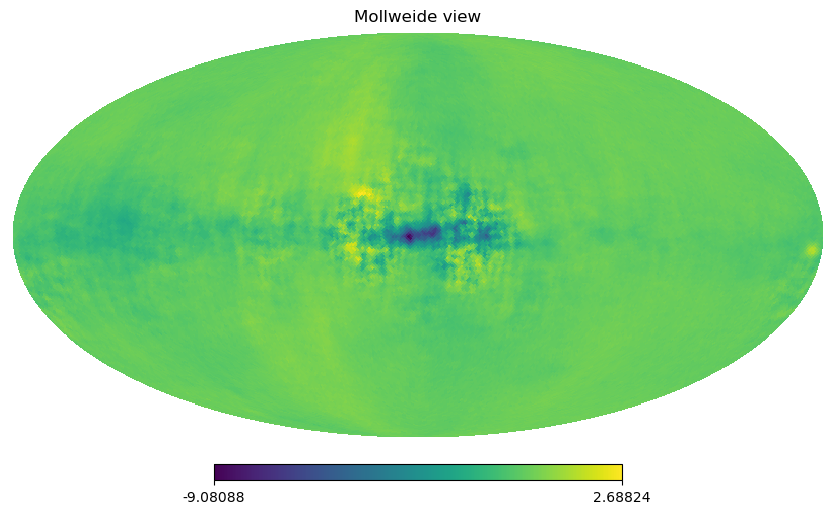

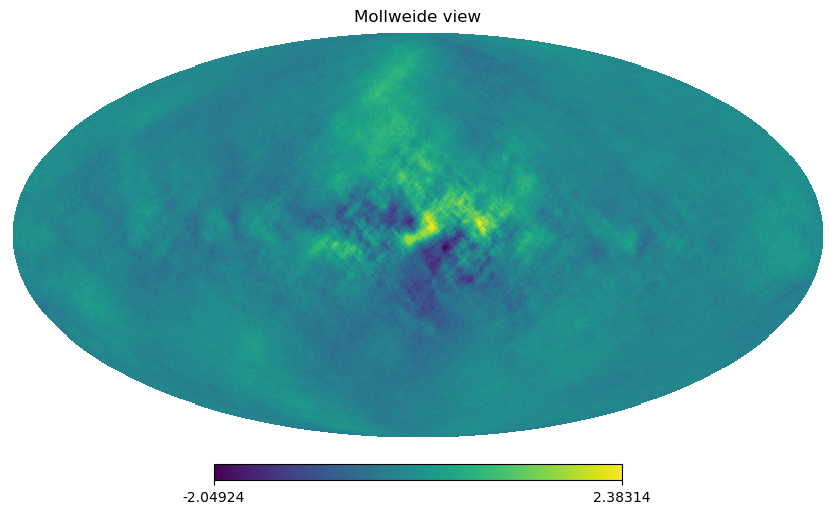

In [17]:
hp.mollview(first_residual[0])
hp.mollview(first_residual[1])

In [18]:
regularization_constant = -1
regularization_factor = 10**10

In [19]:
from functools import partial


In [20]:
# jitted_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX = jax.jit(get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX, static_argnames=['number_components', 'nstokes', 'nside', 'lmin', 'n_iter', 'limit_iter_cg', 'tolerance', 'with_prints', 'regularization_constant', 'regularization_factor'])

def new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(params_mixing_matrix, **model_kwargs):
    new_mixing_matrix = jnp.ones((param_dict['number_frequencies'],param_dict['number_components']))
    # new_mixing_matrix[0,1] = 0
    # new_mixing_matrix[-1,-1] = 0
    # new_mixing_matrix[1:,1:-1] = jnp.array(params_mixing_matrix.reshape((param_dict['number_frequencies']-2,param_dict['number_components']-1)))
    new_mixing_matrix = new_mixing_matrix.at[0,1].set(0)
    new_mixing_matrix = new_mixing_matrix.at[-1,-1].set(0)
    new_mixing_matrix = new_mixing_matrix.at[1:-1,1:].set(jnp.array(params_mixing_matrix.reshape((param_dict['number_frequencies']-2,param_dict['number_components']-1))))
    # print("Test ", model_kwargs['with_prints'], flush=True)
    return katame.get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), jnp.array(model_kwargs['eta_prime_maps']), freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=model_kwargs['with_prints'], regularization_constant=regularization_constant, regularization_factor=regularization_factor)

    

In [21]:
%%time

# Calculation value log_proba with current value of B_f

# log_proba = katame.get_conditional_proba_mixing_matrix_foregrounds(mixing_matrix_obj.params, mixing_matrix_obj, full_data_without_CMB, eta_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True)
log_proba = new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(mixing_matrix_obj.params, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant, regularization_factor=regularization_factor)
print("Log_proba :", log_proba)
print("<-> Proba :", jnp.exp(log_proba))

CG-Python-0 WF finished in  None iterations !!
Log_proba : 0.7046376852756462
<-> Proba : 2.0231135482896843
CPU times: user 4.04 s, sys: 432 ms, total: 4.47 s
Wall time: 2.15 s


In [22]:
jitted_new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX = jax.jit(new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX, static_argnames=['with_prints'])

In [23]:
%%time

# Calculation value log_proba with current value of B_f
log_proba = jitted_new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(mixing_matrix_obj.params, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant, regularization_factor=regularization_factor)
print("Log_proba :", log_proba)
print("<-> Proba :", jnp.exp(log_proba))

Log_proba : 0.7046376852756462
<-> Proba : 2.0231135482896843
CPU times: user 3.64 s, sys: 458 ms, total: 4.09 s
Wall time: 1.68 s


In [24]:
initial_guess_fg_mixing_matrix = mixing_matrix_obj.params.ravel()
dimensions_mixing_matrix = len(initial_guess_fg_mixing_matrix)
full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.95,high=initial_guess_fg_mixing_matrix*1.05, size=(dimensions_mixing_matrix))

In [25]:
with_prints = False

number_steps_sampler = 1000
n_walkers = 10

kernel = MetropolisHastings(new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX, step_size=0.5)
mcmc = MCMC(kernel, num_chains=n_walkers, num_warmup=0, num_samples=number_steps_sampler)


/var/folders/f8/p6tqlgxj2qn5x_tyjrvc1vnh0000gn/T/ipykernel_48680/3170581572.py:7: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_chains=n_walkers, num_warmup=0, num_samples=number_steps_sampler)


In [26]:
initial_guess_fg_mixing_matrix = mixing_matrix_obj.params.ravel()
dimensions_mixing_matrix = len(initial_guess_fg_mixing_matrix)
full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.95,high=initial_guess_fg_mixing_matrix*1.05, size=(n_walkers,dimensions_mixing_matrix))
# full_initial_guess[0] = np.copy(initial_guess_fg_mixing_matrix)
print(mixing_matrix_obj.params, full_initial_guess)

[[2.88437073e-03 1.42538127e+00]
 [3.87988155e-03 1.91733692e+00]
 [4.78088211e-03 2.36258805e+00]
 [6.05138552e-03 2.99043791e+00]
 [7.65722878e-03 3.78400404e+00]
 [9.51435510e-03 4.70174773e+00]
 [1.34402136e-02 6.64180528e+00]
 [1.91378742e-02 9.45744151e+00]
 [2.89375202e-02 1.43001726e+01]
 [4.51218444e-02 2.22980462e+01]
 [8.22050595e-02 4.06236102e+01]
 [1.60639545e-01 7.93839004e+01]
 [3.76180475e-01 1.85898642e+02]] [[2.92834804e-03 1.46349871e+00 4.06789466e-03 1.92503568e+00
  4.57607724e-03 2.38689609e+00 6.10300985e-03 3.11859455e+00
  7.73681295e-03 3.74205033e+00 9.51158050e-03 4.60971696e+00
  1.40097474e-02 6.38531659e+00 1.84245518e-02 9.48918698e+00
  3.02362677e-02 1.40143382e+01 4.32632450e-02 2.16149278e+01
  8.18898390e-02 4.08992535e+01 1.59479564e-01 8.15760463e+01
  3.57486345e-01 1.91012328e+02]
 [2.96436695e-03 1.40632698e+00 3.95688139e-03 1.86292382e+00
  4.79586130e-03 2.37260022e+00 5.86613342e-03 3.08965132e+00
  7.52688570e-03 3.79803660e+00 9.6644974

In [27]:
mcmc.run(random.PRNGKey(0), init_params=full_initial_guess, full_data_without_CMB=jnp.array(full_data_without_CMB), eta_prime_maps=jnp.array(eta_prime_maps), freq_inverse_noise=jnp.array(freq_inverse_noise), red_cov_approx_matrix=jnp.array(red_cov_approx_matrix), param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints)
samples = mcmc.get_samples(group_by_chain=False)
mcmc.print_summary()


sample: 100%|██████████| 1000/1000 [19:48<00:00,  1.19s/it]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 Param:0[0]      0.38     13.67     -0.20    -22.82     15.60      7.82      2.81
 Param:0[1]      4.31     12.51      3.67    -13.48     30.50      7.58      2.71
 Param:0[2]      0.09      9.02      0.49    -13.48     17.23      9.38      2.56
 Param:0[3]      3.36     11.45      3.35    -20.08     22.13      7.97      2.44
 Param:0[4]     -0.99     10.32     -0.69    -25.48     10.36      8.65      2.11
 Param:0[5]      0.33      7.55      1.39    -11.36     13.28     10.58      2.04
 Param:0[6]      1.48     10.33      1.63    -15.18     15.85     10.41      2.20
 Param:0[7]      1.11     10.39      0.94    -17.05     15.00      9.67      2.37
 Param:0[8]     -4.68      9.56     -3.51    -19.19     10.71     11.63      2.31
 Param:0[9]      5.22      8.56      4.30    -10.47     18.17      7.90      2.22
Param:0[10]      0.59      9.95      0.49    -15.94     16.62      7.80      2.46
Param:0[11]    

In [32]:
samples = mcmc.get_samples(group_by_chain=True)
ver = 'J1a'
filename_backend_mcmc = "validation_numpyro_step_4_LiteBIRD_{}ver{}".format(nside,ver)
np.save(filename_backend_mcmc, samples)

In [31]:
samples_tset = np.load(filename_backend_mcmc)

FileNotFoundError: [Errno 2] No such file or directory: 'validation_numpyro_step_4_LiteBIRD_64verJ1a.h5'

In [ ]:
chain_samples = mcmc.get_samples(group_by_chain=True)

In [ ]:
gelman_rubin_statistic = numpyro.diagnostics.gelman_rubin(chain_samples)
print(gelman_rubin_statistic.shape)

In [ ]:
# old_sample = kernel.init(random.PRNGKey(0), init_params=full_initial_guess, full_data_without_CMB=jnp.array(full_data_without_CMB), eta_prime_maps=jnp.array(eta_prime_maps), freq_inverse_noise=jnp.array(freq_inverse_noise), red_cov_approx_matrix=jnp.array(red_cov_approx_matrix), param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints)


# all_samples = np.zeros((number_steps_sampler, n_walkers, dimensions_mixing_matrix))

# for iteration in range(number_steps_sampler):
#     new_sample = kernel.sample(old_sample, full_data_without_CMB=jnp.array(full_data_without_CMB), eta_prime_maps=jnp.array(eta_prime_maps), freq_inverse_noise=jnp.array(freq_inverse_noise), red_cov_approx_matrix=jnp.array(red_cov_approx_matrix), param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints)

#     old_sample = new_sample


#     # Only check convergence every 100 steps
#     if iteration % 100:
#         continue

#     # Compute the autocorrelation time so far
#     # Using tol=0 means that we'll always get an estimate even
#     # if it isn't trustworthy
#     tau = sample_params_mixing_matrix_FG.get_autocorr_time(tol=0)
#     autocorr[index] = np.mean(tau)
#     index += 1


In [ ]:
samples.shape

(700, 1, 8)

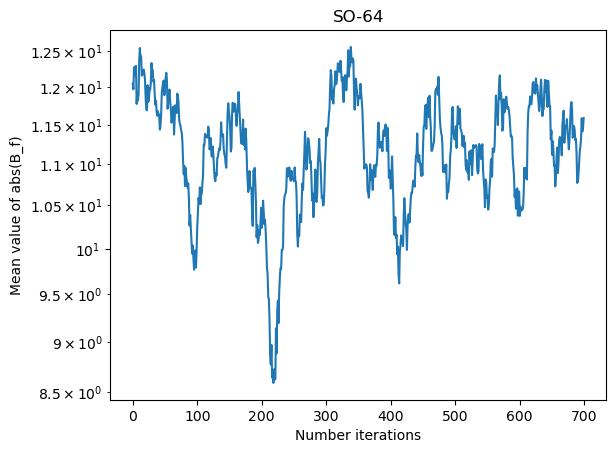

In [ ]:
plt.plot(np.arange(number_steps_sampler), np.abs(samples.mean(axis=(2))))
# plt.plot(np.arange(number_steps_sampler), np.abs(samples.mean(axis=(1,2))))
plt.yscale('log')
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Mean value of abs(B_f)')
plt.show()

In [ ]:
autocorrelation = numpyro.diagnostics.autocorrelation(samples)
autocovariance = numpyro.diagnostics.autocovariance(samples)



In [ ]:
autocorrelation.shape

(700, 1, 8)

In [ ]:
autocovariance.shape

(700, 1, 8)

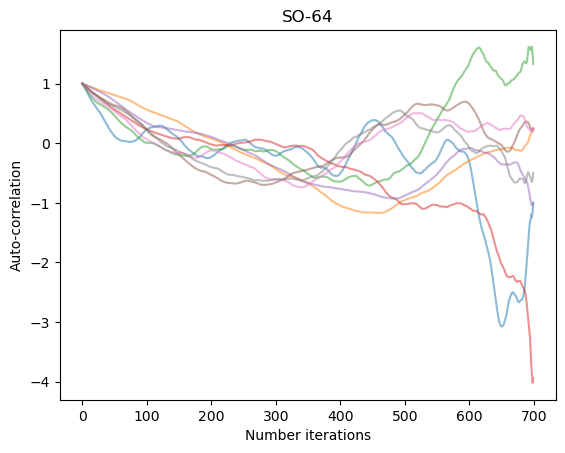

In [ ]:

plt.plot(np.arange(number_steps_sampler), autocorrelation[:,0,:], alpha=.5)
# plt.plot(np.arange(number_steps_sampler), np.mean(autocorrelation[:,0,:],axis=1), 'k')
# plt.loglog()
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Auto-correlation')
plt.show()

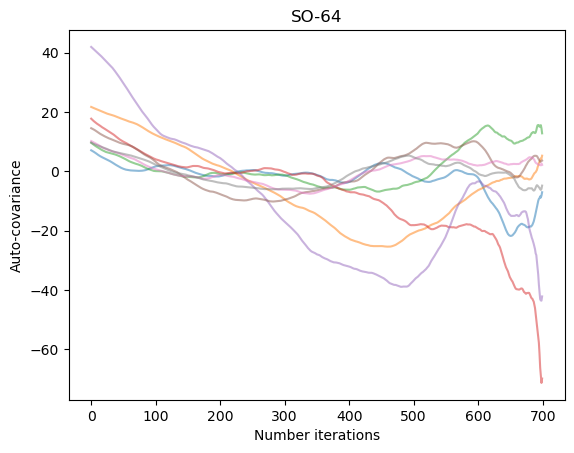

In [ ]:

plt.plot(np.arange(number_steps_sampler), autocovariance[:,0,:], alpha=.5)
# plt.plot(np.arange(number_steps_sampler), np.mean(autocorrelation[:,0,:],axis=1), 'k')
# plt.loglog()
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Auto-covariance')
plt.show()

In [ ]:
autocorrelation_times = np.array([1 + 2*(autocorrelation[i*100:(i+1)*100]/autocorrelation[i*100]).sum(axis=0) for i in range(7)])

In [ ]:
autocorrelation_times

array([[[   63.79095859,   161.09999382,    92.57021867,   118.28840687,
           140.00609   ,   127.25284414,   106.32375782,   124.70962088]],

       [[   36.13165418,   117.98385449, -3269.36898061,    88.14224889,
           128.78817579,  -166.22666612,  -386.79518031,  -109.06069047]],

       [[   57.40231003,  -417.4126455 ,   200.64159748,   -49.771898  ,
          -237.7484772 ,   245.3334249 ,   576.9414696 ,   277.548081  ]],

       [[  252.02666278,   327.10426618,   687.17852401,  2473.33222267,
           311.9451764 ,   135.31273953,   197.66334663,   169.83234917]],

       [[  -22.84121669,   213.27659937,   183.99638445,   331.68981548,
           224.29592965,  -114.16293229,   -55.83473957,  -462.63759895]],

       [[  192.70499288,   140.01772333,  -195.44609265,   204.70822879,
           111.9853972 ,   258.79124916,   194.04872554,    98.90293358]],

       [[ 1272.21949916,    78.94380689,   192.86804936,   358.05416182,
           835.13471414,    55.03

In [ ]:
import emcee.autocorr

In [ ]:
# https://github.com/dfm/emcee/blob/59b6a34323022bc547c3a9fb2173cbffe806af9b/src/emcee/backends/backend.py#L130
emcee.autocorr.integrated_time(samples, tol=0)

array([59.53177363, 85.31270358, 57.24913837, 91.02485449, 81.28128676,
       48.91212108, 53.95907357, 52.25562043])

In [ ]:
# %%time


# # And now sampling B_f using emcee

# n_walkers = 20
# # We have 6*3 parameters to sample, trying to go with 100 steps first
# # number_steps_sampler = 1000
# number_steps_sampler = 700
# with_prints = False

# # whole_chain_samples = katame.sample_mixing_matrix_term(param_dict, mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, red_cov_approx_matrix, freq_inverse_noise, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=10**(-12), n_walkers=n_walkers, number_steps_sampler=number_steps_sampler, with_prints=with_prints)

# initial_guess_fg_mixing_matrix = mixing_matrix_obj.params.ravel()
# dimensions_mixing_matrix = len(initial_guess_fg_mixing_matrix)

# backend = emcee.backends.HDFBackend(filename_backend_mcmc)
# backend.reset(n_walkers, dimensions_mixing_matrix) # To reset the file !

# # sample_params_mixing_matrix_FG = emcee.EnsembleSampler(n_walkers, dimensions_mixing_matrix, get_conditional_proba_mixing_matrix_foregrounds, args=[mixingmatrix_object, full_data_without_CMB, eta_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin, n_iter, limit_iter_cg, tolerance, with_prints])
# sample_params_mixing_matrix_FG = emcee.EnsembleSampler(n_walkers, dimensions_mixing_matrix, get_conditional_proba_mixing_matrix_foregrounds, args=[mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin, n_iter, limit_iter_cg, tolerance_CG, with_prints], backend=backend)

# # We'll track how the average autocorrelation time estimate changes
# index = 0
# autocorr = np.empty(number_steps_sampler)

# # This will be useful to testing convergence
# old_tau = np.inf

# # Initial guess
# # full_initial_guess = np.random.randn(n_walkers,dimensions_mixing_matrix)
# full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.05,high=initial_guess_fg_mixing_matrix*1.05, size=(n_walkers,dimensions_mixing_matrix))
# full_initial_guess[0] = np.copy(initial_guess_fg_mixing_matrix)

# # final_position_walkers = sample_params_mixing_matrix_FG.run_mcmc(full_initial_guess, number_steps_sampler)

# # Now we'll sample for up to number_steps_sampler steps
# for sample in sample_params_mixing_matrix_FG.sample(full_initial_guess, iterations=number_steps_sampler, progress=True):
#     # Only check convergence every 100 steps
#     if sample_params_mixing_matrix_FG.iteration % 100:
#         continue

#     # Compute the autocorrelation time so far
#     # Using tol=0 means that we'll always get an estimate even
#     # if it isn't trustworthy
#     tau = sample_params_mixing_matrix_FG.get_autocorr_time(tol=0)
#     autocorr[index] = np.mean(tau)
#     index += 1

#     # Check convergence
#     converged = np.all(tau * 100 < sample_params_mixing_matrix_FG.iteration)
#     converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
#     if converged:
#         break
#     old_tau = tau


In [ ]:
mixing_matrix_sampled = last_sample

In [ ]:
cp_cp_noise = katame.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
cp_freq_inv_noise_sqrt = katame.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
cp_freq_inv_noise = katame.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

residual_post_sampling = input_cmb_maps[0] - np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0]

In [ ]:
hp.mollview(residual_post_sampling[0][0])
hp.mollview(residual_post_sampling[0][1])

## Sample study

In [ ]:
ell_arange = np.arange(c_ells_input.shape[1])

In [ ]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-2
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)